# Session 3: The Classical ML Lifecycle & Drift
## From Evaluation to Model Decay

**Objective:**
1.  Train standard models on imbalanced data (Simulating the "Absenteeism" case).
2.  Visualize **Confusion Matrices** to understand Precision vs. Recall.
3.  Simulate **Model Drift** to see why retraining is necessary.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score

# Set style for plots
plt.style.use('seaborn-v0_8-whitegrid')

### Part 1: Generating "Absenteeism" Data (Imbalanced)
We simulate a dataset where **90%** of employees are Present (Class 0) and **10%** are Absent (Class 1). This imbalance makes "Accuracy" a dangerous metric.

In [8]:
# Generate synthetic data
X, y = make_classification(
    n_samples=2000,
    n_features=7,
    n_informative=5,
    n_redundant=1,
    weights=[0.70, 0.30],
    flip_y=0.02,
    random_state=42
)

# Split into Train (Past) and Test (Current)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Training Set shape: {X_train.shape}")
print(f"Class Balance: {np.bincount(y_test)[0]} Present vs {np.bincount(y_test)[1]} Absent")

Training Set shape: (1400, 7)
Class Balance: 425 Present vs 175 Absent


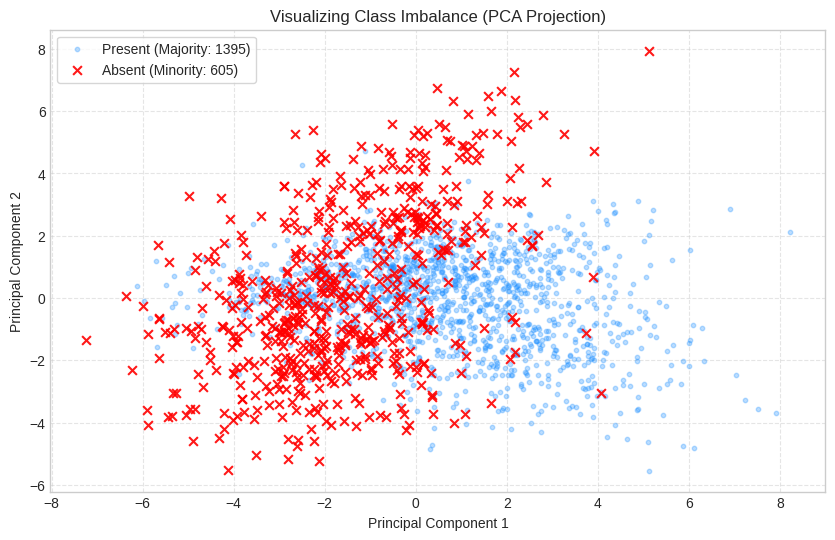

In [9]:
from sklearn.decomposition import PCA

# Reduce dimensions from 10 to 2 for easy visualization
# We use PCA to flatten the complex data into a 2D map
pca = PCA(n_components=2)
X_vis = pca.fit_transform(X)

plt.figure(figsize=(10, 6))

# Plot Majority Class (Present - Blue dots)
# We make these transparent (alpha=0.3) so they look like a "background"
plt.scatter(X_vis[y == 0, 0], X_vis[y == 0, 1],
            label=f'Present (Majority: {np.sum(y==0)})',
            alpha=0.3, s=10, color='dodgerblue')

# Plot Minority Class (Absent - Red Xs)
# We make these opaque and distinct to show the "needle in the haystack"
plt.scatter(X_vis[y == 1, 0], X_vis[y == 1, 1],
            label=f'Absent (Minority: {np.sum(y==1)})',
            alpha=0.9, s=40, color='red', marker='x')

plt.title("Visualizing Class Imbalance (PCA Projection)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(frameon=True)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

### Part 2: Model Training & Confusion Matrices
We will compare a **Logistic Regression** (Simple) vs. a **Random Forest** (Complex).

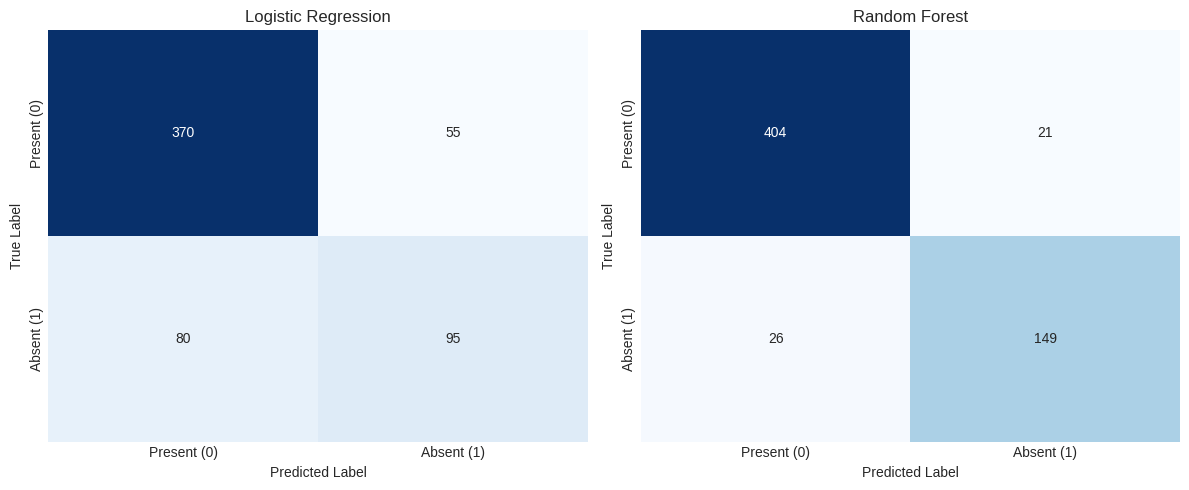

In [10]:
# Initialize Models
model_lr = LogisticRegression()
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train Models
model_lr.fit(X_train, y_train)
model_rf.fit(X_train, y_train)

# Predictions
pred_lr = model_lr.predict(X_test)
pred_rf = model_rf.predict(X_test)

# Function to plot Confusion Matrix
def plot_cm(y_true, y_pred, title, ax):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
    ax.set_title(title)
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')
    ax.set_xticklabels(['Present (0)', 'Absent (1)'])
    ax.set_yticklabels(['Present (0)', 'Absent (1)'])

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_cm(y_test, pred_lr, "Logistic Regression", axes[0])
plot_cm(y_test, pred_rf, "Random Forest", axes[1])
plt.tight_layout()
plt.show()

In [11]:
# Compare Metrics
print("--- Logistic Regression Metrics ---")
print(f"Accuracy: {accuracy_score(y_test, pred_lr):.3f} (Looks high!)")
print(f"F1 Score: {f1_score(y_test, pred_lr):.3f} (The real story)")

print("\n--- Random Forest Metrics ---")
print(f"Accuracy: {accuracy_score(y_test, pred_rf):.3f}")
print(f"F1 Score: {f1_score(y_test, pred_rf):.3f}")

--- Logistic Regression Metrics ---
Accuracy: 0.775 (Looks high!)
F1 Score: 0.585 (The real story)

--- Random Forest Metrics ---
Accuracy: 0.922
F1 Score: 0.864


### Part 3: Simulating Model Drift
Imagine time passes. We are now in "Month 1", "Month 2", etc. 
The model stays the same (frozen), but the world changes (Drift).

We will simulate **Concept Drift** by slowly shifting the feature values of the 'Absent' class.

Simulating deployment over 6 months...


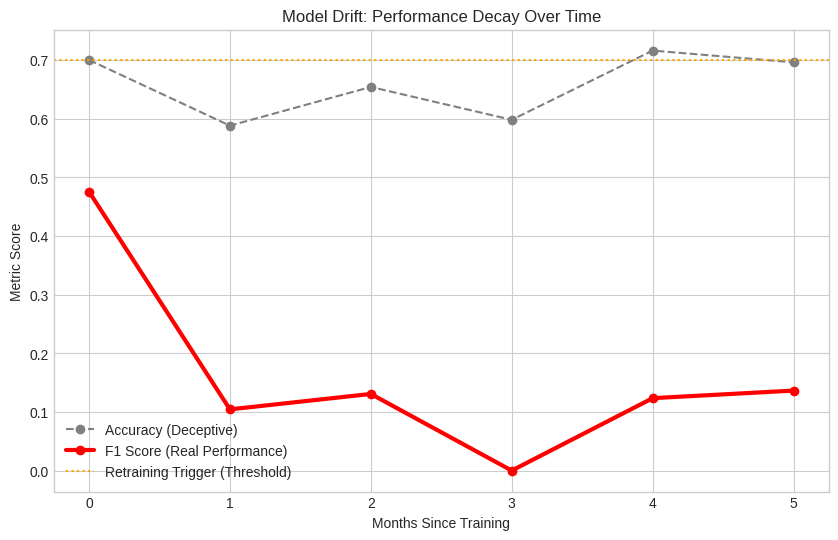

In [13]:
# Simulation Parameters
months = [0, 1, 2, 3, 4, 5]
f1_history = []
accuracy_history = []

# We stick with the trained Random Forest
fixed_model = model_rf

print("Simulating deployment over 6 months...")

for month in months:
    # Generate new data for this month
    # DRIFT LOGIC: Every month, we shift the mean of the features slightly
    drift_factor = month * 0.4  # The world changes a bit every month

    X_month, y_month = make_classification(
        n_samples=500,
        n_features=7,
        n_informative=5,
        n_redundant=1,
        weights=[0.70, 0.30],
        shift=drift_factor, # <--- THIS INTRODUCES DRIFT
        random_state=month + 100
    )

    # Predict using the OLD model on NEW data
    preds = fixed_model.predict(X_month)

    # Record metrics
    f1_history.append(f1_score(y_month, preds))
    accuracy_history.append(accuracy_score(y_month, preds))

# Visualization of Decay
plt.figure(figsize=(10, 6))
plt.plot(months, accuracy_history, marker='o', linestyle='--', color='gray', label='Accuracy (Deceptive)')
plt.plot(months, f1_history, marker='o', linewidth=3, color='red', label='F1 Score (Real Performance)')

plt.title("Model Drift: Performance Decay Over Time")
plt.xlabel("Months Since Training")
plt.ylabel("Metric Score")
plt.axhline(y=0.7, color='orange', linestyle=':', label='Retraining Trigger (Threshold)')
plt.legend()
plt.grid(True)
plt.show()

**Conclusion:**
1.  Accuracy remained relatively stable (because the model kept predicting "Present" correctly).
2.  **F1 Score crashed** as the model lost the ability to detect the shifting "Absent" cases.
3.  This chart proves why we need **MLOps** and continuous monitoring.